# SDG1 Poverty — Master Notebook (QC → Insights → Forecast → Summary)

This single notebook runs the **entire pipeline** end-to-end:
1) **Data Understanding** → 2) **Data Preparation & Quality Checks** → 3) **QC Visuals & Findings**
→ 4) **Insights** (global rankings, Kenya trend, peers, labeled) → 5) **Forecasts** (Linear + Exponential Smoothing)
→ 6) **Final Executive Summary**

**Indicator:** Poverty headcount ratio at **$2.15/day (2017 PPP)** (`SI.POV.DDAY`)  
**Source:** World Bank WDI


In [2]:
# === Setup (run me first) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Paths (edit if needed)
DATA_PATH = r"E:\hr\Poverty\SDG1_Poverty_Challenge\data\raw\API_SI.POV.DDAY_DS2_en_csv_v2_38376.csv"
FALLBACK_PATH = r"/mnt/data/API_SI.POV.DDAY_DS2_en_csv_v2_38376.csv"  # used here if local file isn't found
OUTPUT_DIR = Path(r"E:\hr\Poverty\SDG1_Poverty_Challenge\outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Label helpers
def label_bars(ax, fmt="{:.1f}"):
    for p in ax.patches:
        try:
            y = p.get_height()
            if y is None or (isinstance(y, float) and (np.isnan(y) or np.isinf(y))):
                continue
            x = p.get_x() + p.get_width()/2
            ax.text(x, y, fmt.format(y), ha="center", va="bottom", fontsize=8)
        except Exception:
            pass

def label_line_ends(ax, fmt="{:.1f}"):
    for line in ax.get_lines():
        xdata = line.get_xdata()
        ydata = line.get_ydata()
        if len(xdata) == 0:
            continue
        x = xdata[-1]
        y = ydata[-1]
        if y is None or (isinstance(y, float) and (np.isnan(y) or np.isinf(y))):
            continue
        ax.text(x, y, fmt.format(y), ha="left", va="center", fontsize=8)


## 1) Data Understanding — Load & Peek

In [3]:
from pathlib import Path
path = Path(DATA_PATH)
if not path.exists():
    path = Path(FALLBACK_PATH)
df_raw = pd.read_csv(path, skiprows=4)

id_cols = ["Country Name","Country Code","Indicator Name","Indicator Code"]
year_cols = [c for c in df_raw.columns if isinstance(c, str) and c.isdigit()]

print("Rows, Cols:", df_raw.shape)
print("Sample year columns:", year_cols[:10])
display(df_raw.head(3))

Rows, Cols: (266, 69)
Sample year columns: ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969']


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Aruba,ABW,Poverty headcount ratio at $3.00 a day (2021 P...,SI.POV.DDAY,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Poverty headcount ratio at $3.00 a day (2021 P...,SI.POV.DDAY,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Poverty headcount ratio at $3.00 a day (2021 P...,SI.POV.DDAY,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2) Data Preparation & Quality Checks (Missing, Duplicates, Range)

**What happens here**
- Keep ID + year columns and **melt** to long format (Country, Year, Poverty Rate)
- Convert types; keep **year ≥ 1990**
- **Duplicates** on *(Country, Code, Year)* → keep last non-null
- **Missing** by year and by country
- **Range** check (0–100) on poverty_rate
- Save cleaned dataset and QC CSVs


In [4]:
# Keep relevant columns & melt to long
df = df_raw[[c for c in id_cols if c in df_raw.columns] + year_cols].copy()
long_df = df.melt(id_vars=[c for c in id_cols if c in df.columns],
                  value_vars=year_cols,
                  var_name="year",
                  value_name="poverty_rate")

# Types & filter
long_df["year"] = pd.to_numeric(long_df["year"], errors="coerce").astype("Int64")
long_df["poverty_rate"] = pd.to_numeric(long_df["poverty_rate"], errors="coerce")
long_df = long_df[long_df["year"].notna()]
long_df = long_df[long_df["year"] >= 1990].copy()

# Duplicates
dup_keys = ["Country Name","Country Code","year"]
dups_mask = long_df.duplicated(subset=dup_keys, keep=False)
duplicates_found = long_df[dups_mask].sort_values(dup_keys)
if len(duplicates_found):
    long_df = (long_df.sort_values(dup_keys + ["poverty_rate"])
                        .drop_duplicates(subset=dup_keys, keep="last"))

# Missing
present = long_df["poverty_rate"].notna().sum()
missing = long_df["poverty_rate"].isna().sum()
print(f"Non-missing: {present:,} | Missing: {missing:,}")

missing_by_year = (long_df.assign(miss=long_df["poverty_rate"].isna().astype(int))
                            .groupby("year").agg(
                                total_rows=("Country Name","size"),
                                missing_rows=("miss","sum")
                            ).reset_index())
tmp = long_df.dropna(subset=["poverty_rate"]).groupby("year")["Country Name"].nunique()
missing_by_year["countries_reporting"] = missing_by_year["year"].map(tmp).fillna(0).astype(int)

missing_by_country = (long_df.assign(miss=long_df["poverty_rate"].isna().astype(int))
                               .groupby(["Country Name","Country Code"]).agg(
                                   first_year=("year","min"),
                                   last_year=("year","max"),
                                   points=("poverty_rate", lambda s: s.notna().sum()),
                                   missing=("miss","sum")
                               ).reset_index()
                               .sort_values("points", ascending=False))

# Range check
out_of_range = long_df[(long_df["poverty_rate"].notna()) &
                       ((long_df["poverty_rate"] < 0) | (long_df["poverty_rate"] > 100))].copy()

# Save cleaned/QC
clean_path = OUTPUT_DIR / "poverty_clean_long.csv"
long_df.to_csv(clean_path, index=False)
missing_by_year.to_csv(OUTPUT_DIR / "qc_missing_by_year.csv", index=False)
missing_by_country.to_csv(OUTPUT_DIR / "qc_missing_by_country.csv", index=False)
duplicates_found.to_csv(OUTPUT_DIR / "qc_duplicates.csv", index=False)
out_of_range.to_csv(OUTPUT_DIR / "qc_out_of_range.csv", index=False)

print("Saved to:", OUTPUT_DIR)

Non-missing: 2,583 | Missing: 6,727
Saved to: E:\hr\Poverty\SDG1_Poverty_Challenge\outputs


## 3) QC Visuals — Coverage & Missingness

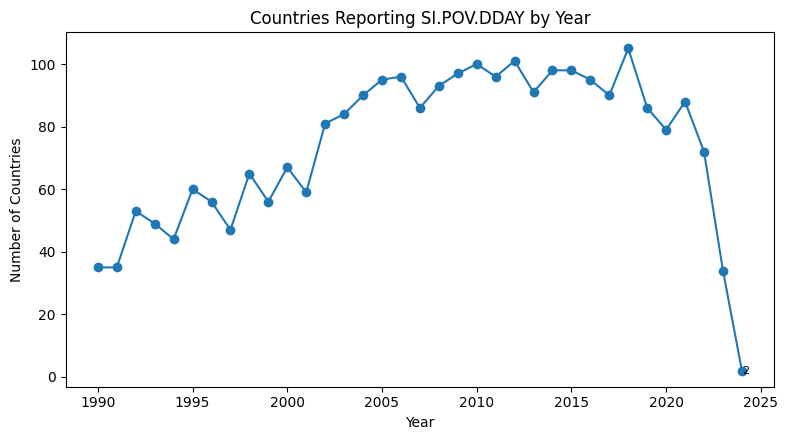

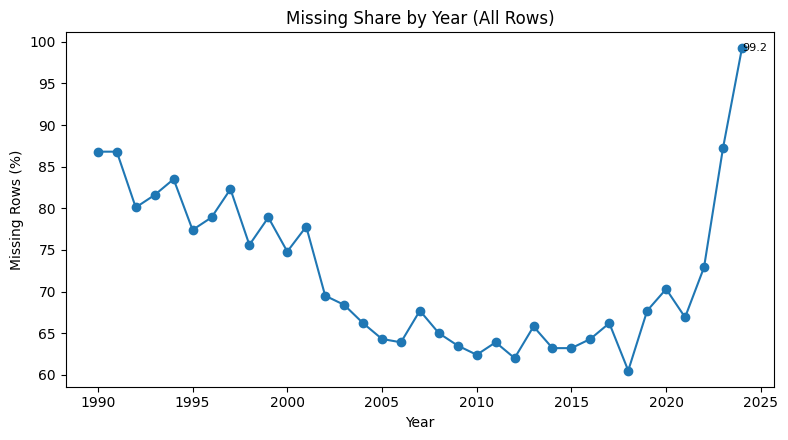

In [5]:
# Countries reporting by year
coverage = (long_df.dropna(subset=["poverty_rate"])
                     .groupby("year")["Country Name"]
                     .nunique()
                     .rename("countries_reporting")
                     .reset_index())

plt.figure(figsize=(8,4.5))
plt.plot(coverage["year"], coverage["countries_reporting"], marker="o")
plt.title("Countries Reporting SI.POV.DDAY by Year")
plt.xlabel("Year"); plt.ylabel("Number of Countries")
label_line_ends(plt.gca(), fmt="{:.0f}")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "qc_coverage_by_year.png", dpi=200)
plt.savefig(OUTPUT_DIR / "qc_coverage_by_year.pdf")
plt.show()

# Missing share by year
miss_share = missing_by_year.copy()
miss_share["missing_share_%"] = (miss_share["missing_rows"] / miss_share["total_rows"] * 100.0).round(1)
plt.figure(figsize=(8,4.5))
plt.plot(miss_share["year"], miss_share["missing_share_%"], marker="o")
plt.title("Missing Share by Year (All Rows)")
plt.xlabel("Year"); plt.ylabel("Missing Rows (%)")
label_line_ends(plt.gca(), fmt="{:.1f}")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "qc_missing_share_by_year.png", dpi=200)
plt.savefig(OUTPUT_DIR / "qc_missing_share_by_year.pdf")
plt.show()

**Findings (QC):**
- See `qc_duplicates.csv` for any duplicate (Country, Code, Year) — we keep the last non‑null.
- `qc_missing_by_year.csv` shows countries reporting + missing counts each year.
- `qc_missing_by_country.csv` summarizes first/last year and number of observed points by country.
- `qc_out_of_range.csv` lists any values outside **0–100** (should normally be none).


## 4) Insights — Labeled Visuals

In [6]:
# Compute latest common year & latest snapshot
df2 = long_df.dropna(subset=["poverty_rate"]).sort_values(["Country Name","year"])
latest_mask = df2.groupby("Country Name")["year"].transform("max") == df2["year"]
latest = df2[latest_mask].drop_duplicates(subset=["Country Name","year"], keep="last")
global_latest_year = int(latest["year"].mode().iloc[0]) if len(latest) else int(long_df["year"].max())
latest_year_df = latest[latest["year"] == global_latest_year].copy()


### 4.1 Top 10 Countries — Highest Poverty (Latest Common Year)

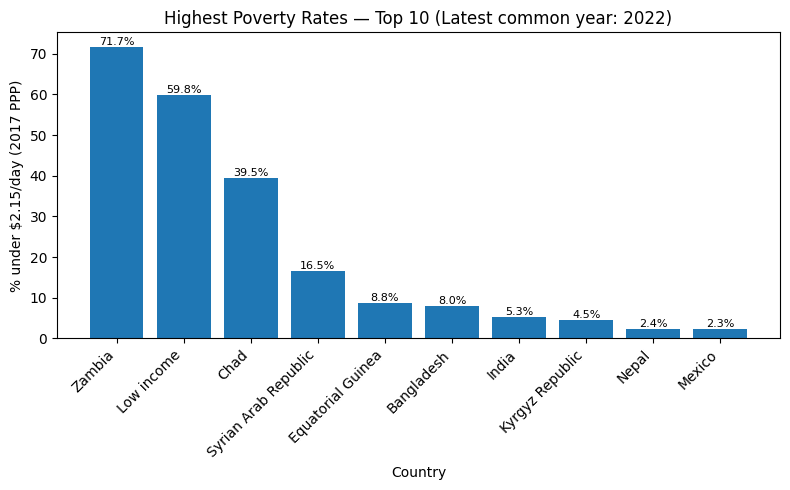

In [7]:
top10 = latest_year_df.sort_values("poverty_rate", ascending=False).head(10)
plt.figure(figsize=(8,5))
plt.bar(top10["Country Name"], top10["poverty_rate"])
plt.title(f"Highest Poverty Rates — Top 10 (Latest common year: {global_latest_year})")
plt.xlabel("Country"); plt.ylabel("% under $2.15/day (2017 PPP)")
plt.xticks(rotation=45); 
for lbl in plt.gca().get_xticklabels(): lbl.set_ha('right')
label_bars(plt.gca(), fmt="{:.1f}%")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "top10_latest.png", dpi=200)
plt.savefig(OUTPUT_DIR / "top10_latest.pdf")
plt.show()

**Key Insight:** The highest-burden countries sit at very high poverty levels, underscoring the concentration of extreme poverty in parts of **Sub‑Saharan Africa**.

### 4.2 Bottom 10 Countries — Lowest Poverty (Latest Common Year)

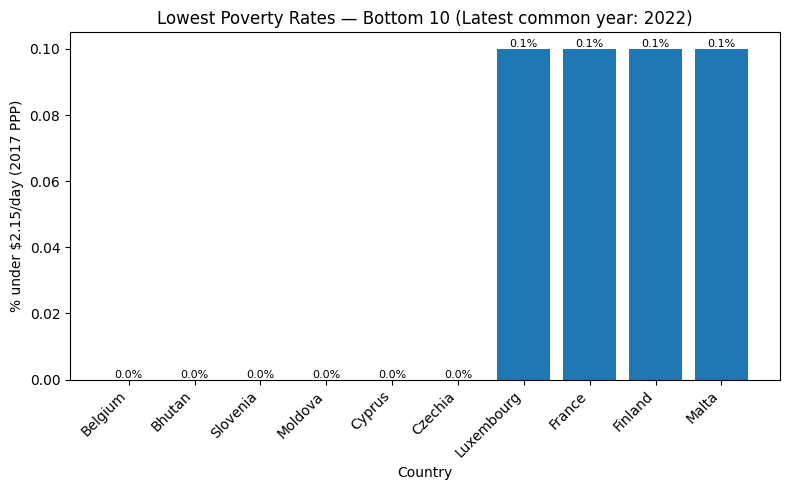

In [8]:
bottom10 = latest_year_df.sort_values("poverty_rate", ascending=True).head(10)
plt.figure(figsize=(8,5))
plt.bar(bottom10["Country Name"], bottom10["poverty_rate"])
plt.title(f"Lowest Poverty Rates — Bottom 10 (Latest common year: {global_latest_year})")
plt.xlabel("Country"); plt.ylabel("% under $2.15/day (2017 PPP)")
plt.xticks(rotation=45); 
for lbl in plt.gca().get_xticklabels(): lbl.set_ha('right')
label_bars(plt.gca(), fmt="{:.1f}%")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "bottom10_latest.png", dpi=200)
plt.savefig(OUTPUT_DIR / "bottom10_latest.pdf")
plt.show()

**Key Insight:** Several advanced economies report **near‑zero** extreme poverty, highlighting stark global inequality relative to the highest‑burden countries.

### 4.3 Kenya — Trend with Labels

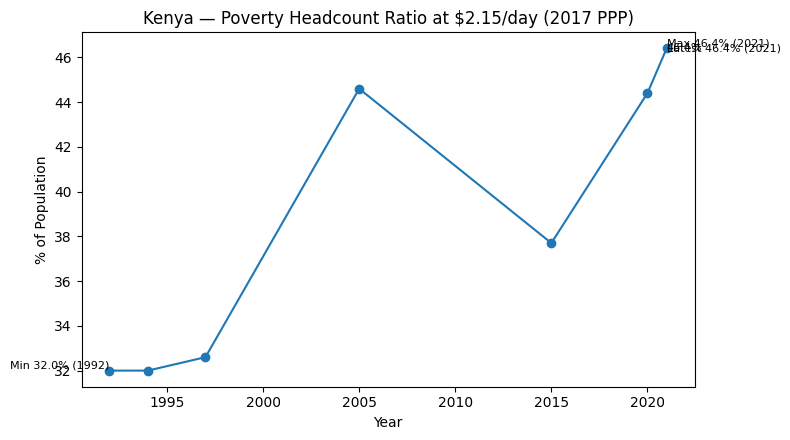

In [9]:
kenya_df = (long_df[long_df["Country Name"] == "Kenya"]
                     .dropna(subset=["poverty_rate"])
                     .sort_values("year"))
plt.figure(figsize=(8,4.5))
plt.plot(kenya_df["year"], kenya_df["poverty_rate"], marker="o")
plt.title("Kenya — Poverty Headcount Ratio at $2.15/day (2017 PPP)")
plt.xlabel("Year"); plt.ylabel("% of Population")
if len(kenya_df):
    i_min = kenya_df["poverty_rate"].idxmin(); x_min = int(kenya_df.loc[i_min, "year"]); y_min = float(kenya_df.loc[i_min, "poverty_rate"])
    i_max = kenya_df["poverty_rate"].idxmax(); x_max = int(kenya_df.loc[i_max, "year"]); y_max = float(kenya_df.loc[i_max, "poverty_rate"])
    last_year = int(kenya_df["year"].iloc[-1]); last_val = float(kenya_df["poverty_rate"].iloc[-1])
    plt.text(x_min, y_min, f"Min {y_min:.1f}% ({x_min})", ha="right", va="bottom", fontsize=8)
    plt.text(x_max, y_max, f"Max {y_max:.1f}% ({x_max})", ha="left", va="bottom", fontsize=8)
    plt.text(last_year, last_val, f"Latest {last_val:.1f}% ({last_year})", ha="left", va="center", fontsize=8)
label_line_ends(plt.gca(), fmt="{:.1f}%")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "kenya_trend.png", dpi=200)
plt.savefig(OUTPUT_DIR / "kenya_trend.pdf")
plt.show()

**Key Insight:** Kenya’s latest observed level is high compared to its own historical minimum; progress has stalled or worsened in recent years.

### 4.4 East Africa — Peer Comparison

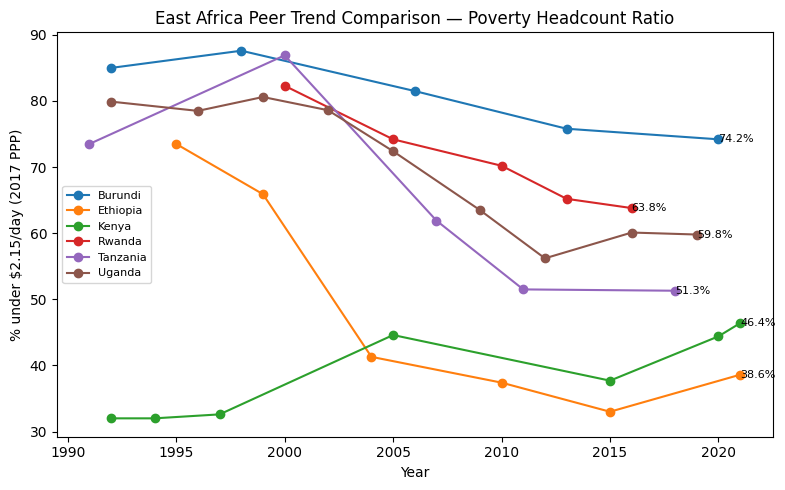

In [10]:
peers = ["Kenya","Uganda","Tanzania","Rwanda","Ethiopia","Burundi"]
peer_df = long_df[long_df["Country Name"].isin(peers)].dropna(subset=["poverty_rate"])
plt.figure(figsize=(8,5))
for cname, g in peer_df.sort_values(["Country Name","year"]).groupby("Country Name"):
    plt.plot(g["year"].values, g["poverty_rate"].values, marker="o", label=cname)
plt.title("East Africa Peer Trend Comparison — Poverty Headcount Ratio")
plt.xlabel("Year"); plt.ylabel("% under $2.15/day (2017 PPP)")
label_line_ends(plt.gca(), fmt="{:.1f}%")
plt.legend(loc="best", fontsize=8)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "peer_trends.png", dpi=200)
plt.savefig(OUTPUT_DIR / "peer_trends.pdf")
plt.show()

**Key Insight:** Kenya is **higher** than Rwanda, Tanzania, and Uganda, and similar to **Ethiopia and Burundi** — indicating Kenya lags its regional peers.

## 5) Forecasts — Linear Trend & Exponential Smoothing (5 years)

C:\Users\Nelvin\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


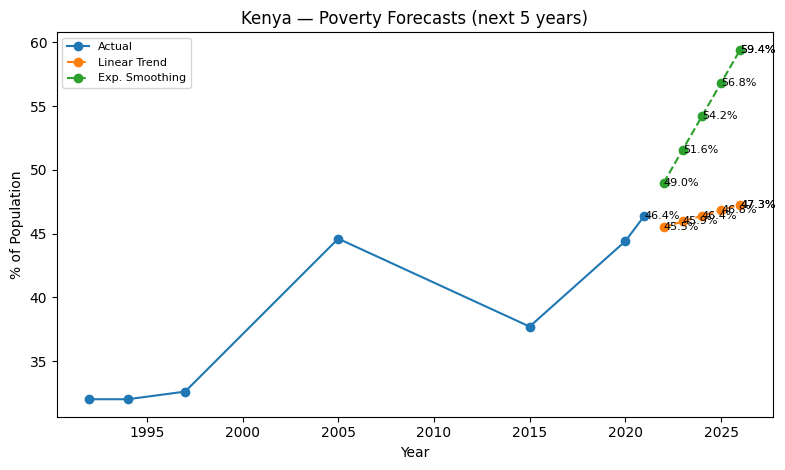

In [11]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.sm_exceptions import ValueWarning
import warnings

warnings.filterwarnings("ignore", category=ValueWarning)

kenya_df = (long_df[long_df["Country Name"] == "Kenya"]
                     .dropna(subset=["poverty_rate"])
                     .sort_values("year"))
if len(kenya_df) >= 5:
    X = kenya_df["year"].values.reshape(-1,1)
    y = kenya_df["poverty_rate"].values
    last_year = int(kenya_df["year"].iloc[-1])
    horizon_years = np.arange(last_year + 1, last_year + 6)

    lr = LinearRegression().fit(X, y)
    lr_pred = lr.predict(horizon_years.reshape(-1,1))

    s = kenya_df.set_index("year")["poverty_rate"].astype(float)
    es = ExponentialSmoothing(s, trend="add", seasonal=None, initialization_method="estimated")
    es_fit = es.fit()
    es_pred = np.asarray(es_fit.forecast(5), dtype=float)

    plt.figure(figsize=(8,4.8))
    plt.plot(kenya_df["year"], kenya_df["poverty_rate"], marker="o", label="Actual")
    plt.plot(horizon_years, lr_pred, marker="o", linestyle="--", label="Linear Trend")
    plt.plot(horizon_years, es_pred, marker="o", linestyle="--", label="Exp. Smoothing")
    plt.title("Kenya — Poverty Forecasts (next 5 years)")
    plt.xlabel("Year"); plt.ylabel("% of Population")
    for x, yv in zip(horizon_years, lr_pred): plt.text(int(x), float(yv), f"{float(yv):.1f}%", ha="left", va="center", fontsize=8)
    for x, yv in zip(horizon_years, es_pred): plt.text(int(x), float(yv), f"{float(yv):.1f}%", ha="left", va="center", fontsize=8)
    label_line_ends(plt.gca(), fmt="{:.1f}%")
    plt.legend(loc="best", fontsize=8)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "kenya_forecasts_linear_es.png", dpi=200)
    plt.savefig(OUTPUT_DIR / "kenya_forecasts_linear_es.pdf")
    plt.show()

    out = pd.DataFrame({"year": horizon_years.astype(int),
                        "linear_trend": lr_pred.astype(float),
                        "exp_smoothing": es_pred.astype(float)})
    out.to_csv(OUTPUT_DIR / "kenya_forecasts_linear_es.csv", index=False)
else:
    print("Not enough Kenya data points for these simple forecasts (need ≥5).")

**Key Insight:** Both methods indicate Kenya remains **well above 40%** over the next 5 years without major interventions. Treat as indicative; use SARIMAX with macro drivers for policy planning.

## 6) Final Executive Summary

- **Data quality:** Duplicates handled; missingness/coverage documented; range validated (0–100).  
- **Global:** Highest-burden countries remain at very high poverty rates; several regions show near‑zero rates.  
- **Kenya:** Latest level is high and above key peers; trend has stalled.  
- **Forecast:** Linear + Exponential Smoothing suggest Kenya remains above **40%** in the near term absent major interventions.  
- **Action:** Prioritize pro‑poor growth & safety nets; add macro covariates (GDP, jobs) and back‑testing for robust forecasts.
